# Coursework Assignment 2: Measuring Sentence Similarity
The purpose of this file is to help you develop your model. You **DON'T** need to submit this file. In the end, you should submit
* A report, summarising all your findings and analyses.
* For task 1 (MLP-based model), submit two files: **test_mlp.ipynb** which includes the impelementation, and **best_mlp.state_dict**, which is the saved MLP weights.
* For task 2 (CNN- or RNN-based model), submit two files: **test_cnn.ipynb** (if you developed a RNN model, change cnn to rnn) which includes the impelementation, and **best_cnn.state_dict**, which is the saved CNN/RNN weights.
* For task 3 (additional models), similarly, submit the implementation as well as the saved weights.


## Load Data

In [37]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer,LancasterStemmer
from nltk import ConditionalFreqDist,FreqDist,pos_tag
from nltk.corpus import stopwords
import string

In [35]:
# read data
train_data = pd.read_csv('cw2_train.csv')
dev_data = pd.read_csv('cw2_dev.csv')
train_dataframe = train_data.copy()

train_data

,Unnamed: 0,Sent1,Sent2,SimScore
0,0,"U.S., EU Widen Sanctions On Russia","U.S., EU Boost Sanctions On Russia",1.00
1,1,The lawyers advised the judges .,The lawyers advised the judges behind the acto...,0.79
2,2,Man kills 4 in Calif. before police shoot him ...,Police: Gunman killed 6 in California shootings,0.40
3,3,Someone is playing a piano.,A man is playing a guitar.,0.24
4,4,In an E-mail statement to the Knoxville News S...,I am not giving any consideration to resignati...,0.80
...,...,...,...,...
11493,11493,A man is playing piano.,A man is laying on the ground.,0.15
11494,11494,"The doctors resigned , or the secretaries supp...",The doctors resigned .,0.50
11495,11495,The artist contacted the banker .,The banker contacted the artist by the student .,0.29
11496,11496,"While the professors arrived , the student wai...",The professors arrived .,0.61


# Data Preprocessing

In [65]:
def pos_tagging(pos):
    if pos.startswith('N'):
        return 'n'
    elif pos.startswith('V'):
        return 'v'
    elif pos =='JJ' or pos == 'JJR':
        return 'a'
    elif pos.startswith('R'):
        return 'r'
    elif pos == 'JJS':
        return 's'
    else:
        return None
    
def remove_stopwords(sent_words):
    return [ww for ww in sent_words 
            if ww.lower() not in stop_words and ww not in string.punctuation]


lemmatizer = WordNetLemmatizer()
lemma_result = []
stop_words=set(stopwords.words('english'))

for i in np.arange(len(train_data)):
    tagged_sent1 = pos_tag(remove_stopwords(word_tokenize(train_dataframe.Sent1[i])))
    tagged_sent2 = pos_tag(remove_stopwords(word_tokenize(train_dataframe.Sent2[i])))
    train_dataframe.replace(train_dataframe.Sent1[i],' '.join([lemmatizer.lemmatize(k[0]) if pos_tagging(str(k[1]))==None else lemmatizer.lemmatize(k[0],pos_tagging(str(k[1]))) for k in tagged_sent1]),inplace=True)
    train_dataframe.replace(train_dataframe.Sent2[i],' '.join([lemmatizer.lemmatize(l[0]) if pos_tagging(str(l[1]))==None else lemmatizer.lemmatize(l[0],pos_tagging(str(l[1]))) for l in tagged_sent2]),inplace=True)
    

In [66]:
train_dataframe

,Unnamed: 0,Sent1,Sent2,SimScore
0,0,U.S. EU Widen Sanctions Russia,U.S. EU Boost Sanctions Russia,1.00
1,1,lawyer advise judge,lawyer advise judge behind actor,0.79
2,2,Man kill 4 Calif. police shoot dead,Police Gunman kill 6 California shooting,0.40
3,3,Someone playing piano,man play guitar,0.24
4,4,E-mail statement Knoxville News Sentinel Shuma...,give consideration resignation '' Shumaker say...,0.80
...,...,...,...,...
11493,11493,man play piano,man lay ground,0.15
11494,11494,doctor resign secretary support lawyer,doctor resign,0.50
11495,11495,artist contact banker,banker contact artist student,0.29
11496,11496,professor arrive student wait,professor arrive,0.61


## Load Pre-Trained Embeddings
In the sample code below, the Glove pre-trained embedding is used. Feel free to use other embeddings if you find it appropriate.

In [29]:
# load pre-trained glove embeddings
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import numpy as np

word_vec_dim = 300
# specify the loaction of the downloaded glove file
path_of_downloaded_files = "/Users/nithinkyatham/Desktop/MSc AI/2nd Term/NLP CS5990j/env/NLP/cw2-files/glove.6B.{}d.txt".format(word_vec_dim)
glove_file = datapath(path_of_downloaded_files)
word2vec_glove_file = get_tmpfile("glove.6B.300d.txt")
glove2word2vec(glove_file, word2vec_glove_file)
word_vectors = KeyedVectors.load_word2vec_format(word2vec_glove_file)

oov_vec = np.random.rand(word_vec_dim)

def get_sent_word_vecs(word_vectors, sent_words):
    vecs = []
    for ww in sent_words:
        if ww in word_vectors:
            vecs.append(word_vectors[ww])
        else:
            vecs.append(oov_vec)
    return np.array(vecs)

<ipython-input-29-7a3881dfa30c>:12: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, word2vec_glove_file)


## Define the Sentence Encoder
Below, a simple model to create vector representations for sentences is provided. It first computes the average of the words embeddings, and then passes the average embedding to a fully-connected layer and applies a non-linear activation function to generate the final vector. You should develop more advanced models!

In [82]:
# define the baseline model
import numpy as np
import torch
import torch.nn as nn

class BaselineModel(nn.Module):
    def __init__(self, embd_dim):
        super(BaselineModel, self).__init__()
        self.relu = nn.ReLU()
        self.fully_connected_layer = nn.Linear(embd_dim, embd_dim)
        self.relu = nn.ReLU()
        self.fully_connected_layer = nn.Linear(embd_dim, embd_dim)
        
    def forward(self, sent1_vecs, sent2_vecs):
        avg_embd1 = torch.mean(torch.FloatTensor(sent1_vecs), dim=0).unsqueeze(0)
        avg_embd2 = torch.mean(torch.FloatTensor(sent2_vecs), dim=0).unsqueeze(0)
        sent1_repr = self.relu(self.fully_connected_layer(avg_embd1))
        sent2_repr = self.relu(self.fully_connected_layer(avg_embd2))
        
        return sent1_repr, sent2_repr

## Training Pipeline
The function *train_model* below provides a general pipeline for training the sentence encoder model. You could re-use it for training the model you have developed.

In [31]:
from tqdm.notebook import tqdm

def train_model(train_data, n_epochs, lr, optimizer, loss_fnc, model):
    cos_sim = nn.CosineSimilarity()
    for epoch_i in tqdm(range(n_epochs)):
        ep_loss = []
        cnt = 0
        for i, entry in tqdm(train_data.sample(frac=1).iterrows()):
            cnt += 1
            sent1 = entry['Sent1']
            sent2 = entry['Sent2']
            sent1_embds = get_sent_word_vecs(word_vectors, sent1.split())
            sent2_embds = get_sent_word_vecs(word_vectors, sent2.split())

            # Step 1: Clear the gradients 
            optimizer.zero_grad()

            # Step 2: Compute the forward pass of the model
            sent1_repr, sent2_repr = model(sent1_embds, sent2_embds)
            pred_sim = cos_sim(sent1_repr, sent2_repr)
            true_sim = torch.FloatTensor([entry['SimScore']])

            # Step 3: Compute the loss value that we wish to optimize
            loss = loss_fnc(pred_sim, true_sim)
            ep_loss.append(loss.detach())

            # Step 4: Propagate the loss signal backward
            loss.backward()

            # Step 5: Trigger the optimizer to perform one update
            optimizer.step()

            if  cnt%1000 == 0:
                print('epoch {}, avg loss until step {}: {}'.format(epoch_i, cnt, np.mean(ep_loss)))
        scheduler.step()
        print('\n======epoch {} loss======'.format(epoch_i),np.mean(ep_loss))
        

## Provide Hyper-Parameters and Start the Training
The hyper-parameters and optimizers provided below are just some examples. You should use appropriate strategy to find the hyper-parameters that you want to use!

In [83]:
model = BaselineModel(word_vec_dim)
loss_fnc = nn.MSELoss()

# hyper parameters
n_epochs = 2
#lr = 1e-3
exp_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
multi_step_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

# init optimizer and scheduler (lr adjustor)
import torch.optim as optim
adam_optimizer = optim.Adam(params=model.parameters(), lr=lr)
#swa = optim.swa_utils.SWALR(optimizer,anneal_strategy="linear",swa_lr=0.01)

train_model(train_dataframe, n_epochs, multi_step_scheduler, adam_optimizer, loss_fnc, model)

epoch 0, avg loss until step 1000: 0.12439439445734024
epoch 0, avg loss until step 2000: 0.12212403863668442
epoch 0, avg loss until step 3000: 0.11653298139572144
epoch 0, avg loss until step 4000: 0.11326777935028076
epoch 0, avg loss until step 5000: 0.11097763478755951
epoch 0, avg loss until step 6000: 0.10838763415813446
epoch 0, avg loss until step 7000: 0.10662712901830673
epoch 0, avg loss until step 8000: 0.10521905869245529
epoch 0, avg loss until step 9000: 0.10503815859556198
epoch 0, avg loss until step 10000: 0.10353940725326538
epoch 0, avg loss until step 11000: 0.10217905789613724


======epoch 0 loss====== 0.10176424


epoch 1, avg loss until step 1000: 0.0901067778468132
epoch 1, avg loss until step 2000: 0.08357927203178406
epoch 1, avg loss until step 3000: 0.08091909438371658
epoch 1, avg loss until step 4000: 0.08374099433422089
epoch 1, avg loss until step 5000: 0.08421073853969574
epoch 1, avg loss until step 6000: 0.08319015800952911
epoch 1, avg loss until step 7000: 0.08279999345541
epoch 1, avg loss until step 8000: 0.0822208970785141
epoch 1, avg loss until step 9000: 0.08202027529478073
epoch 1, avg loss until step 10000: 0.08200044184923172
epoch 1, avg loss until step 11000: 0.08217864483594894


======epoch 1 loss====== 0.081853874



# Learning Rate Adaption and Power Scheduling.

In [ ]:
def powerScheduling(lrold,t):
    return lrnew=(lrold)/1+t

lrAdap = [1,0.1,0.01,0.001,0.0001]

optimizer = optim.Adam(params=model.parameters(), lr=powerScheduling(lr,t))

train_model(train_dataframe, n_epochs, lr, optimizer, loss_fnc, model)

## Evaluate The Trained Model
The function *evaluate_trained_model* defined below tests the performance of a trained model on the dev_set. 

In [68]:
import matplotlib.pyplot as plt
def evaluate_trained_model(trained_model, dev_data):
    pred_scores = []
    true_scores = []
    cos_sim = nn.CosineSimilarity()
    with torch.no_grad(): # let pytorch know that no gradient should be computed
        model.eval()
        for i, entry in tqdm(dev_data.iterrows()):
            sent1 = entry['Sent1']
            sent2 = entry['Sent2']
            gold_score = entry['SimScore']
            sent1_embds = get_sent_word_vecs(word_vectors, sent1.split())
            sent2_embds = get_sent_word_vecs(word_vectors, sent2.split())
            sent1_repr, sent2_repr = trained_model(sent1_embds, sent2_embds)
            pred_sim = cos_sim(sent1_repr, sent2_repr)
        
            pred_scores.append(pred_sim)
            true_scores.append(gold_score)

    assert len(true_scores) == len(pred_scores)
    squared_errors = [np.square(ts-ps) for (ts, ps) in zip(true_scores, pred_scores)]
    print('MSE of the method on the dev set:', np.mean(squared_errors))

    # check the distribution (histo gram) of the squared errors
    plt.hist(squared_errors)


MSE of the method on the dev set: 0.108952515


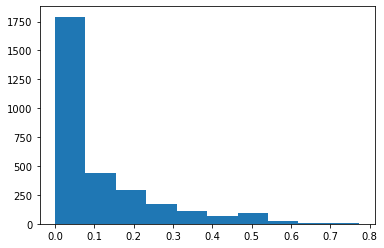

In [84]:
evaluate_trained_model(model, dev_data)

## Save trained model
The code below illustrates how to save the trained model. 

In [86]:
import pickle

info_to_save = {
    'model_state_dict': model.state_dict(),
    'oov_vec': oov_vec
}

with open('sample_model.state_dict', 'wb') as ff:
    pickle.dump(info_to_save, ff)